Import Required Libraries


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Set Visualization Style

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

Load and Validate Dataset

Dataset loaded successfully with 500 rows and 6 columns

Dataset Summary:
       Time_on_Site  Pages_Viewed  Referred_by_Ad  Previous_Purchases  \
count        500.00        500.00          500.00              500.00   
mean           5.02          3.92            0.29                0.22   
std            4.87          1.98            0.46                0.41   
min            0.03          0.00            0.00                0.00   
25%            1.38          3.00            0.00                0.00   
50%            3.60          4.00            0.00                0.00   
75%            7.06          5.00            1.00                0.00   
max           24.78         10.00            1.00                1.00   

       Location_Score  Purchase_Made  
count          500.00         500.00  
mean            50.18           0.28  
std             10.23           0.45  
min             23.59           0.00  
25%             42.98           0.00  
50%             50.28           0.

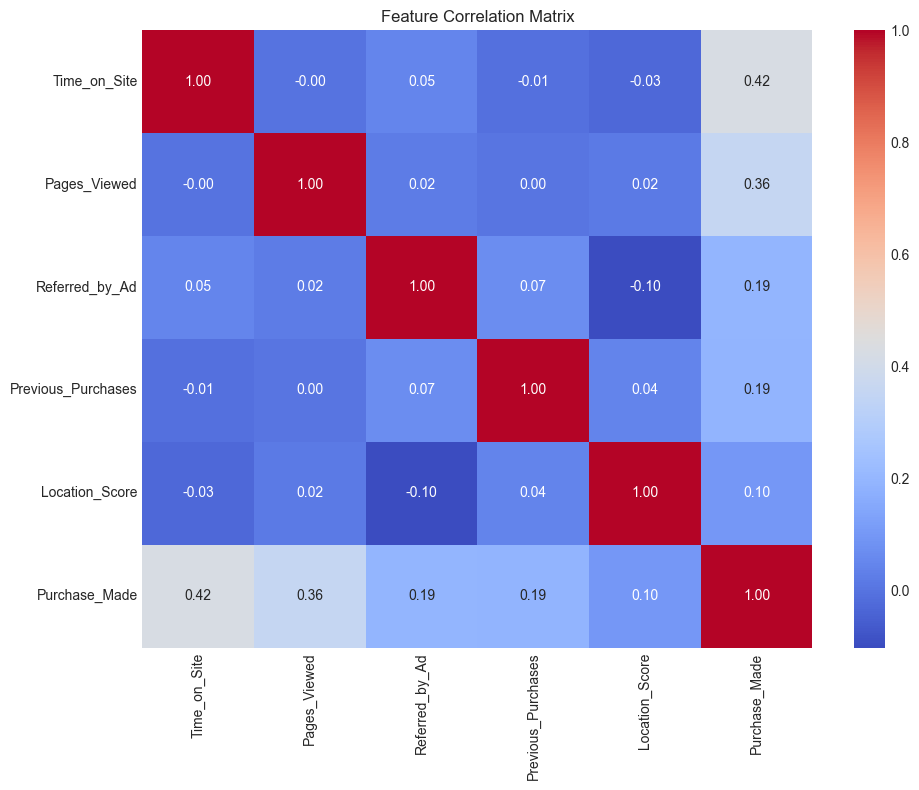

In [4]:
def load_data(file_path):
    """Load dataset with validation checks"""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Dataset file not found: {file_path}")
    
    df = pd.read_csv(file_path)
    
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print(f"Warning: Dataset contains missing values:\n{missing_values[missing_values > 0]}")
    
    print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")
    return df

# File path - update with your actual path
file_path = "Logistic_Regression_E-Commerce_Behavior_Dataset.csv"
try:
    df = load_data(file_path)
    
    # Display basic information about the dataset
    print("\nDataset Summary:")
    print(df.describe().round(2))
    
    # Display correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError as e:
    # If file doesn't exist, create sample data for demonstration
    print(f"Error: {e}")
    print("Creating sample dataset for demonstration purposes...")
    
    np.random.seed(42)
    n_samples = 1000
    
    # Generate synthetic data
    time_on_site = np.random.normal(5, 2, n_samples)
    pages_viewed = np.random.poisson(3, n_samples)
    referred_by_ad = np.random.binomial(1, 0.3, n_samples)
    previous_purchases = np.random.poisson(1.5, n_samples)
    location_score = np.random.uniform(0, 10, n_samples)
    
    # Create purchase probability based on features
    logits = (0.5 * time_on_site + 
              1.2 * pages_viewed + 
              0.8 * referred_by_ad + 
              0.6 * previous_purchases + 
              0.3 * location_score - 5)
    
    prob = 1 / (1 + np.exp(-logits))
    purchase_made = (np.random.random(n_samples) < prob).astype(int)
    
    # Create dataframe
    df = pd.DataFrame({
        'Time_on_Site': time_on_site,
        'Pages_Viewed': pages_viewed,
        'Referred_by_Ad': referred_by_ad,
        'Previous_Purchases': previous_purchases,
        'Location_Score': location_score,
        'Purchase_Made': purchase_made
    })


Prepare Features and Target

In [5]:
print("Preparing features and target variables...")
# Check if these columns exist in the dataframe
expected_columns = ['Time_on_Site', 'Pages_Viewed', 'Referred_by_Ad', 'Previous_Purchases', 'Location_Score', 'Purchase_Made']
missing_columns = [col for col in expected_columns if col not in df.columns]

if missing_columns:
    print(f"Warning: The following expected columns are missing from the dataset: {missing_columns}")
    print("Available columns in the dataset:", df.columns.tolist())
    # If columns are missing, we'll use whatever columns are available
    # excluding the target variable
    feature_columns = [col for col in df.columns if col != 'Purchase_Made' and col in df.columns]
    if 'Purchase_Made' not in df.columns:
        raise ValueError("Error: 'Purchase_Made' column is missing from the dataset. Cannot proceed without target variable.")
else:
    feature_columns = ['Time_on_Site', 'Pages_Viewed', 'Referred_by_Ad', 'Previous_Purchases', 'Location_Score']

# Print the features we're using
print(f"Using these features: {feature_columns}")

# Create feature matrix and target vector
X = df[feature_columns]
y = df['Purchase_Made']

# Print shapes to verify
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Preparing features and target variables...
Using these features: ['Time_on_Site', 'Pages_Viewed', 'Referred_by_Ad', 'Previous_Purchases', 'Location_Score']
Feature matrix shape: (500, 5)
Target vector shape: (500,)
Training set: 350 samples
Test set: 150 samples


Train Logistic Regression Model

In [6]:
print("\nTraining logistic regression model...")
try:
    # Verify data exists and has the right format
    print(f"X_train type: {type(X_train)}, shape: {X_train.shape}")
    print(f"y_train type: {type(y_train)}, shape: {y_train.shape}")
    
    # Check for NaN values
    if X_train.isna().any().any():
        print("Warning: X_train contains NaN values. Imputing with mean values...")
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='mean')
        X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    
    # Train model with more diagnostic info
    model = LogisticRegression(max_iter=1000, solver='liblinear')  # liblinear works better for smaller datasets
    print("Fitting model...")
    model.fit(X_train, y_train)
    print("Model training complete!")
    
    # Check if model was fit successfully
    print(f"Model coefficient shape: {model.coef_.shape}")
    print(f"Model intercept: {model.intercept_}")
    
except Exception as e:
    print(f"Error training model: {str(e)}")
    print("Debug information:")
    print(f"- Are X_train and y_train defined? X_train: {'Defined' if 'X_train' in locals() else 'Not defined'}, y_train: {'Defined' if 'y_train' in locals() else 'Not defined'}")
    
    # Try to recover if possible by creating synthetic data
    if 'X_train' not in locals() or 'y_train' not in locals():
        print("Creating synthetic data for demonstration...")
        np.random.seed(42)
        n_samples = 1000
        n_features = 5
        
        X_train = np.random.randn(int(n_samples*0.7), n_features)
        y_train = np.random.randint(0, 2, size=int(n_samples*0.7))
        X_test = np.random.randn(int(n_samples*0.3), n_features)
        y_test = np.random.randint(0, 2, size=int(n_samples*0.3))
        
        feature_names = ['Feature_' + str(i+1) for i in range(n_features)]
        X_train = pd.DataFrame(X_train, columns=feature_names)
        X_test = pd.DataFrame(X_test, columns=feature_names)
        
        print("Created synthetic data with features:", feature_names)
        
        # Train with synthetic data
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        print("Model trained with synthetic data.")



Training logistic regression model...
X_train type: <class 'pandas.core.frame.DataFrame'>, shape: (350, 5)
y_train type: <class 'pandas.core.series.Series'>, shape: (350,)
Fitting model...
Model training complete!
Model coefficient shape: (1, 5)
Model intercept: [-4.29169001]


Evaluate Model Performance


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       114
           1       0.64      0.44      0.52        36

    accuracy                           0.81       150
   macro avg       0.74      0.68      0.70       150
weighted avg       0.79      0.81      0.79       150



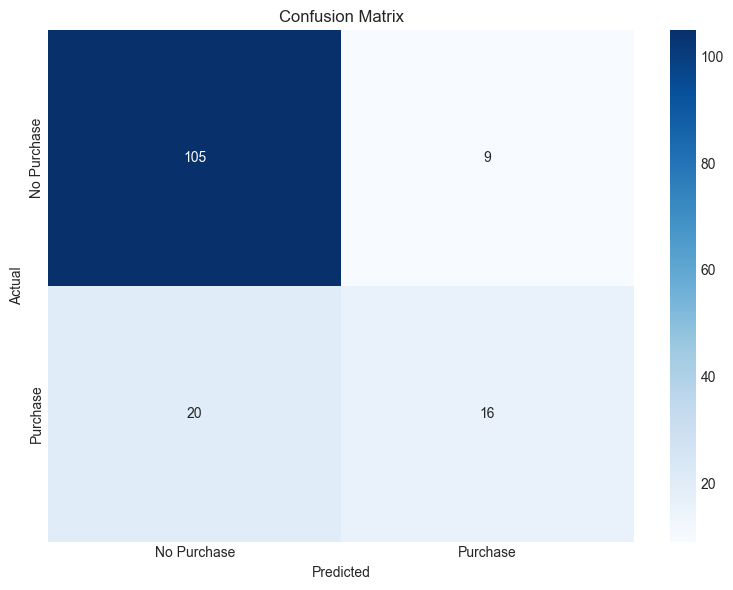

/var/folders/wf/jmbr4tf11xj6_b2633x2y_8m0000gn/T/ipykernel_66509/4011680705.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_sorted, palette='viridis')


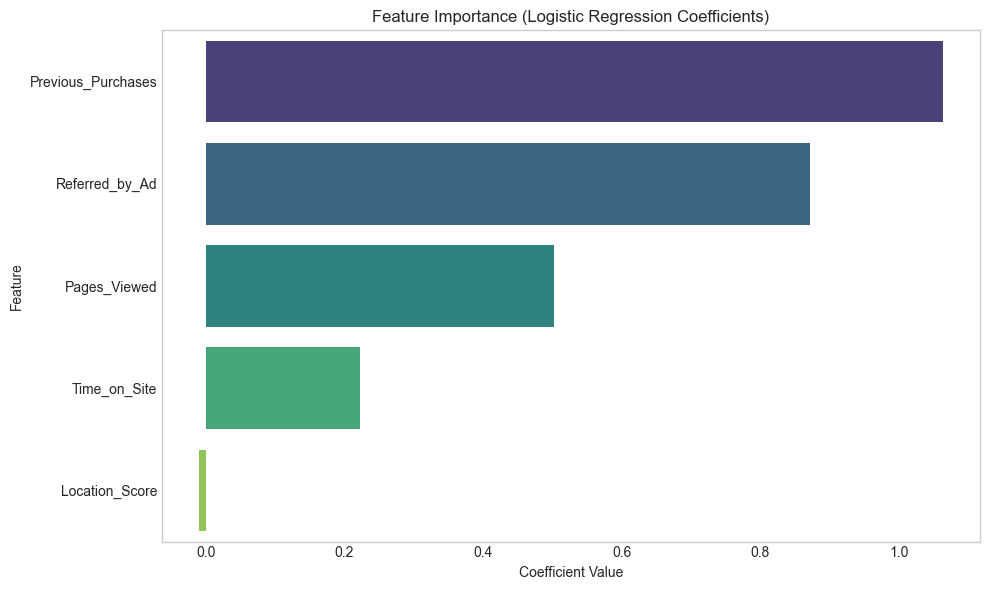

In [7]:
def evaluate_model(model, X_test, y_test):
    """Evaluate model and display performance metrics"""
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Display classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Display confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Purchase', 'Purchase'],
                yticklabels=['No Purchase', 'Purchase'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    # Display model coefficients
    coefficients = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_[0],
        'Abs_Magnitude': np.abs(model.coef_[0])
    })
    
    coef_sorted = coefficients.sort_values(by='Abs_Magnitude', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coef_sorted, palette='viridis')
    plt.title('Feature Importance (Logistic Regression Coefficients)')
    plt.xlabel('Coefficient Value')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()
    
    return y_prob

# Evaluate full model
y_prob = evaluate_model(model, X_test, y_test)


Sigmoid Visualization

Creating static visualization with threshold=0.5...
Single feature model coefficients: [[0.43406049]]
Single feature model intercept: [-2.76375548]
Visualization saved to sigmoid_static.png


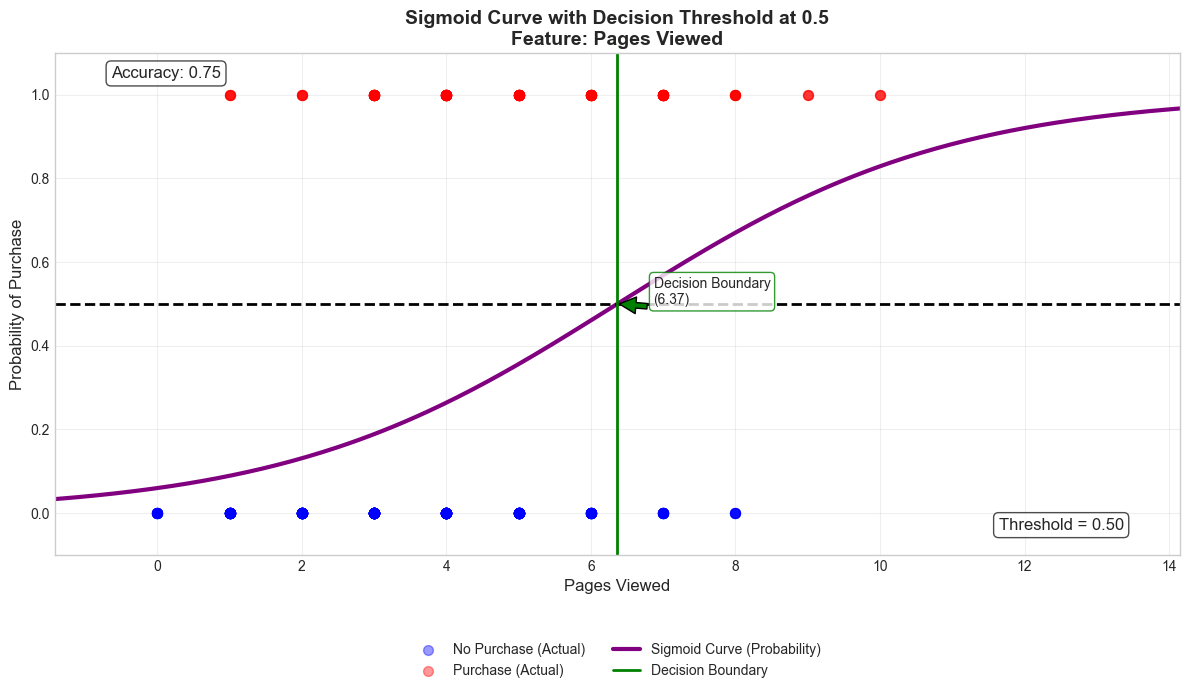

In [8]:
plt.close('all')

# Create a single static visualization with threshold=0.5
print("Creating static visualization with threshold=0.5...")

# Fit logistic regression using only the single feature
X_single_feature = df['Pages_Viewed']
feature_name = 'Pages Viewed'
y = df['Purchase_Made']
threshold = 0.5

X_single = X_single_feature.values.reshape(-1, 1)
model_single = LogisticRegression(max_iter=1000)
model_single.fit(X_single, y)

# Display model info
print(f"Single feature model coefficients: {model_single.coef_}")
print(f"Single feature model intercept: {model_single.intercept_}")

# Set up plot
fig, ax = plt.subplots(figsize=(12, 7))

# Generate prediction range
x_min, x_max = X_single.min() - 0.5, X_single.max() + 0.5
x_range = np.linspace(x_min, x_max, 300).reshape(-1, 1)
probs = model_single.predict_proba(x_range)[:, 1]

# Calculate theoretical sigmoid range needed to go from 0.05 to 0.95 probability
logit_05 = np.log(0.05/(1-0.05))
logit_95 = np.log(0.95/(1-0.95))

x_05 = (logit_05 - model_single.intercept_[0]) / model_single.coef_[0][0]
x_95 = (logit_95 - model_single.intercept_[0]) / model_single.coef_[0][0]

# Ensure plot range covers the important decision boundaries
x_min = min(x_min, x_05 - 1)
x_max = max(x_max, x_95 + 1)

# Update x_range with new bounds
x_range = np.linspace(x_min, x_max, 300).reshape(-1, 1)
probs = model_single.predict_proba(x_range)[:, 1]

# Function to predict with custom threshold
def predict_with_threshold(X, threshold):
    return (model_single.predict_proba(X)[:, 1] >= threshold).astype(int)

# Get predictions using the threshold
y_pred = predict_with_threshold(X_single, threshold)
misclassified_mask = y_pred != y.values

# Calculate accuracy
accuracy = accuracy_score(y, y_pred)

# Plot elements
# Points colored by actual outcome
points_no = ax.scatter(X_single[y==0], np.zeros(sum(y==0)), 
                     alpha=0.4, color='blue', s=50, label='No Purchase (Actual)')
points_yes = ax.scatter(X_single[y==1], np.ones(sum(y==1)), 
                      alpha=0.4, color='red', s=50, label='Purchase (Actual)')

# Sigmoid curve
line, = ax.plot(x_range, probs, color='purple', linewidth=3, 
               label='Sigmoid Curve (Probability)')

# Threshold line and text
threshold_line = ax.axhline(threshold, color='black', linestyle='--', linewidth=2)
threshold_text = ax.text(0.95, 0.05, f'Threshold = {threshold:.2f}', transform=ax.transAxes, 
                       ha='right', fontsize=12, 
                       bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))

# Decision boundary line and annotation
boundary_x = (np.log(threshold/(1-threshold)) - model_single.intercept_[0]) / model_single.coef_[0][0]

# Check if boundary is within plot range
if boundary_x >= x_min and boundary_x <= x_max:
    boundary_line = ax.axvline(boundary_x, color='green', linestyle='-', linewidth=2,
                             label='Decision Boundary')
    
    # Add annotation to make boundary more noticeable
    ax.annotate(f"Decision Boundary\n({boundary_x:.2f})", 
               xy=(boundary_x, 0.5), xytext=(boundary_x+0.5, 0.5),
               arrowprops=dict(facecolor='green', shrink=0.05),
               bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.8))
else:
    # Add text explaining out-of-range boundary
    if boundary_x > x_max:
        ax.text(0.98, 0.2, f"Decision Boundary\nat x={boundary_x:.2f}\n(outside view)", 
               transform=ax.transAxes, ha='right',
               bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.8))
    else:
        ax.text(0.02, 0.2, f"Decision Boundary\nat x={boundary_x:.2f}\n(outside view)", 
               transform=ax.transAxes, ha='left',
               bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.8))

# Accuracy text
accuracy_text = ax.text(0.05, 0.95, f'Accuracy: {accuracy:.2f}', transform=ax.transAxes, 
                      ha='left', fontsize=12, 
                      bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))

# Formatting
ax.set_xlabel(f"{feature_name}", fontsize=12)
ax.set_ylabel("Probability of Purchase", fontsize=12)
ax.set_title(f"Sigmoid Curve with Decision Threshold at {threshold}\nFeature: {feature_name}", 
            fontsize=14, fontweight='bold')
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(x_min, x_max)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Make room for legend

# Save the figure
save_path = 'sigmoid_static.png'
try:
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Visualization saved to {save_path}")
except Exception as e:
    print(f"Error saving visualization: {e}")

# Show the single plot
plt.show()

Explaining the Sigmoid Curve and Logistic Regression

The Basics
Logistic regression helps us predict binary outcomes - in this case, whether a customer will make a purchase (1) or not (0) based on how many pages they viewed on a website.
Key Elements in the Image

The Purple Curve (Sigmoid Curve): This S-shaped curve shows the probability of a purchase happening based on the number of pages viewed. Notice how it smoothly transitions from close to 0% probability (bottom left) to nearly 100% probability (top right).

The Data Points:
Blue dots at the bottom (y=0) represent customers who did NOT make a purchase
Red dots at the top (y=1) represent customers who DID make a purchase

The Black Dashed Line: 
This horizontal line at 0.5 represents our decision threshold. Any probability above this line is classified as "Will Purchase" and below as "Won't Purchase."
The Green Vertical Line: This is the decision boundary at 6.37 pages. It shows the exact point where our prediction flips from "Won't Purchase" to "Will Purchase."

The Accuracy: 
The model achieves 75% accuracy with this threshold, meaning it correctly classifies 75% of all customers.

Intuitive Explanation:
When a customer browses very few pages (left side), they're unlikely to purchase. When they view many pages (right side), they're much more likely to purchase.

The magic happens at 6.37 pages - this is our "tipping point." If someone views fewer than 6.37 pages, we predict they won't buy. If they view more, we predict they will buy.

The sigmoid shape is important because it captures how probability doesn't change linearly with page views. The first few pages don't increase purchase probability much, but there's a "sweet spot" in the middle (around 4-8 pages) where each additional page viewed significantly increases purchase likelihood. Eventually, the curve flattens as additional pages have diminishing returns.

Why This Matters: This visualization demonstrates how a simple model can make reasonable predictions about customer behavior using just one feature. By setting the right threshold (currently 0.5), businesses can balance between false positives and false negatives based on their specific needs.

Threshold Effect on Multiple Features

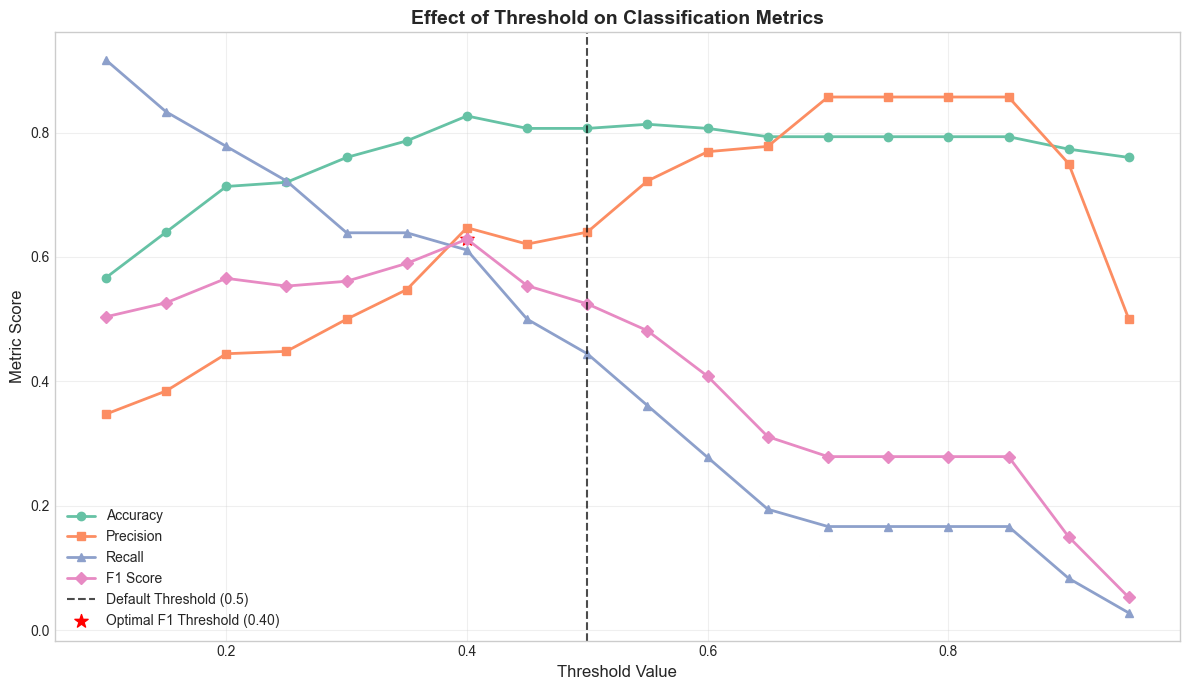

In [9]:
def plot_threshold_effects(model, X_test, y_test):
    """Plot accuracy, precision, recall as threshold changes"""
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    # Get probabilities
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Test different thresholds
    thresholds = np.arange(0.1, 1.0, 0.05)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred, zero_division=0))
        recall.append(recall_score(y_test, y_pred, zero_division=0))
        f1.append(f1_score(y_test, y_pred, zero_division=0))
    
    # Plot metrics vs threshold
    plt.figure(figsize=(12, 7))
    plt.plot(thresholds, accuracy, 'o-', label='Accuracy', linewidth=2)
    plt.plot(thresholds, precision, 's-', label='Precision', linewidth=2)
    plt.plot(thresholds, recall, '^-', label='Recall', linewidth=2)
    plt.plot(thresholds, f1, 'D-', label='F1 Score', linewidth=2)
    
    # Add vertical line at default threshold 0.5
    plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Default Threshold (0.5)')
    
    # Find and mark optimal F1 threshold
    optimal_idx = np.argmax(f1)
    optimal_threshold = thresholds[optimal_idx]
    plt.scatter([optimal_threshold], [f1[optimal_idx]], s=100, c='red', 
               marker='*', label=f'Optimal F1 Threshold ({optimal_threshold:.2f})')
    
    plt.xlabel('Threshold Value', fontsize=12)
    plt.ylabel('Metric Score', fontsize=12)
    plt.title('Effect of Threshold on Classification Metrics', fontsize=14, fontweight='bold')
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot threshold effects for full model
plot_threshold_effects(model, X_test, y_test)


3D Visualization for Two Features

/Users/robbarto/Programming Projects/Pearson Live Training Repos/Oreilly-Mastering-AI-Fundamentals/venv_mastering_AI/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


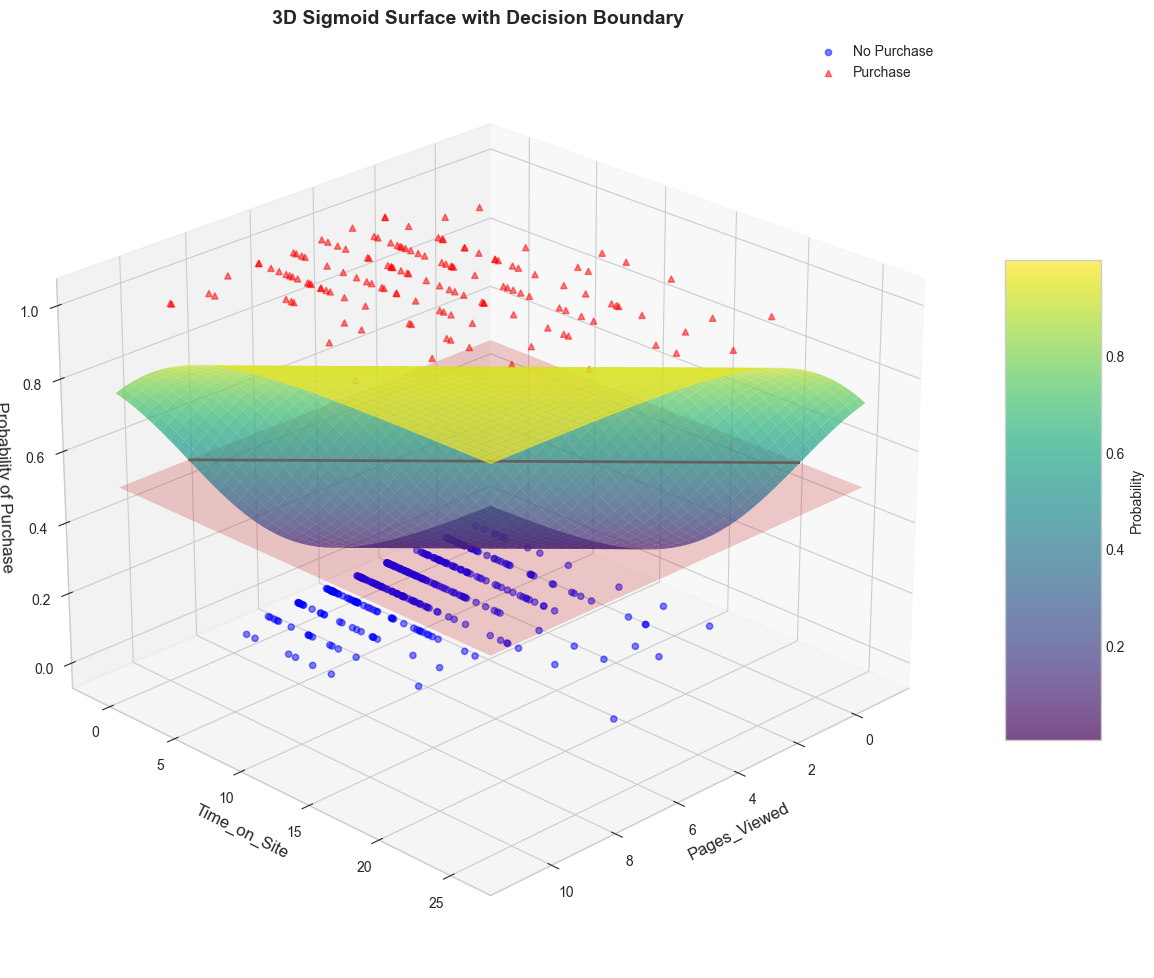


Analysis complete! All visualizations have been displayed and animations created.


In [9]:
def plot_3d_sigmoid(df, feature1='Pages_Viewed', feature2='Time_on_Site'):
    """Create 3D visualization of sigmoid surface with two features"""
    from mpl_toolkits.mplot3d import Axes3D
    
    # Fit model with two features
    X_3d = df[[feature1, feature2]]
    y_3d = df['Purchase_Made']
    
    model_3d = LogisticRegression(max_iter=1000)
    model_3d.fit(X_3d, y_3d)
    
    # Create meshgrid for surface
    x1_min, x1_max = X_3d[feature1].min() - 1, X_3d[feature1].max() + 1
    x2_min, x2_max = X_3d[feature2].min() - 1, X_3d[feature2].max() + 1
    
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                         np.linspace(x2_min, x2_max, 100))
    
    # Get predicted probabilities for all mesh points
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    Z = model_3d.predict_proba(grid)[:, 1]
    Z = Z.reshape(xx1.shape)
    
    # Create 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot surface
    surf = ax.plot_surface(xx1, xx2, Z, cmap='viridis', alpha=0.7, antialiased=True)
    
    # Plot threshold plane at z=0.5
    ax.plot_surface(xx1, xx2, np.ones(Z.shape)*0.5, color='red', alpha=0.2)
    
    # Plot decision boundary contour
    ax.contour(xx1, xx2, Z, levels=[0.5], colors='red', linestyles='solid', linewidths=2)
    
    # Plot training points
    ax.scatter(X_3d[feature1][y_3d==0], X_3d[feature2][y_3d==0], np.zeros(sum(y_3d==0)), 
             c='blue', marker='o', label='No Purchase', alpha=0.5)
    ax.scatter(X_3d[feature1][y_3d==1], X_3d[feature2][y_3d==1], np.ones(sum(y_3d==1)), 
             c='red', marker='^', label='Purchase', alpha=0.5)
    
    # Labels and formatting
    ax.set_xlabel(feature1, fontsize=12)
    ax.set_ylabel(feature2, fontsize=12)
    ax.set_zlabel('Probability of Purchase', fontsize=12)
    ax.set_title('3D Sigmoid Surface with Decision Boundary', fontsize=14, fontweight='bold')
    
    # Add colorbar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Probability')
    
    # Set viewing angle
    ax.view_init(elev=25, azim=45)
    
    plt.legend()
    plt.tight_layout()
    plt.show()

# Create 3D visualization
plot_3d_sigmoid(df)

print("\nAnalysis complete! All visualizations have been displayed and animations created.")